In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI


os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
import operator

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="Decide if the joke is funny or not")
    feedback: str = Field(description="If the joke is not funny, provide feedback on how to improve it.")

evaluator = llm.with_structured_output(Feedback)

In [4]:
def llm_call_generator(state: State):
    """Generate a joke"""
    
    if state.get("feedback"):
        msg = llm.invoke(
            "Write a joke about " + state["topic"] + " but take into account the feedback: " + state["feedback"]
        )
    else:
        msg = llm.invoke(
            "Write a joke about " + state["topic"]
        )

    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """Evaluate the joke"""
    
    grade = evaluator.invoke("Grade the joke: " + state["joke"])
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


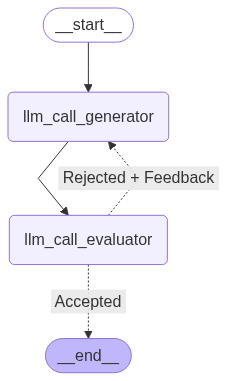

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges("llm_call_evaluator", route_joke, {
    "Accepted": END,
    "Rejected + Feedback": "llm_call_generator"
})

optimizer_graph = optimizer_builder.compile()
display(Image(optimizer_graph.get_graph().draw_mermaid_png()))

In [ ]:
state 